# Load Libraries

In [21]:
import os
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import models
from PIL import Image
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from tqdm import tqdm
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer
from sklearn.metrics import roc_curve, auc, RocCurveDisplay, confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve, average_precision_score, classification_report
from statsmodels.stats.contingency_tables import mcnemar
from sklearn.feature_extraction.text import TfidfVectorizer
from tabulate import tabulate

device = torch.device("cpu")
from google.colab import files
files.upload()
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d alessandrasala79/ai-vs-human-generated-dataset
!kaggle datasets download -d shanegerami/ai-vs-human-text
import kagglehub
shanegerami_ai_vs_human_text_path = kagglehub.dataset_download('shanegerami/ai-vs-human-text')
alessandrasala79_ai_vs_human_generated_dataset_path = kagglehub.dataset_download('alessandrasala79/ai-vs-human-generated-dataset')

print('Data source import complete.')
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


Streaming output truncated to the last 5000 lines.
/kaggle/input/ai-vs-human-generated-dataset/train_data/922eceb9fbd2442999ccaa0db3c67a64.jpg
/kaggle/input/ai-vs-human-generated-dataset/train_data/a49a987698fd404c83401b4fe9997aa2.jpg
/kaggle/input/ai-vs-human-generated-dataset/train_data/0ff64465188f468ea2ced2094703dbbf.jpg
/kaggle/input/ai-vs-human-generated-dataset/train_data/82d47c09950146f093a125504ff7f9aa.jpg
/kaggle/input/ai-vs-human-generated-dataset/train_data/ba45303deb7544a389c8d2ab976dc1a8.jpg
/kaggle/input/ai-vs-human-generated-dataset/train_data/8796e9a1fb884590bda7c29a489db64b.jpg
/kaggle/input/ai-vs-human-generated-dataset/train_data/84a2720850b94ac1b955bb680ce5769f.jpg
/kaggle/input/ai-vs-human-generated-dataset/train_data/92af648f0fca4e9aa1215dae70121c42.jpg
/kaggle/input/ai-vs-human-generated-dataset/train_data/ceb9a77a99014f119b7d76a28de4b5e6.jpg
/kaggle/input/ai-vs-human-generated-dataset/train_data/22f3f6f82231407eb82ac6441640a5bf.jpg
/kaggle/input/ai-vs-human-gen

# SimCLR model

In [37]:
class ImageDataset(Dataset):
    def __init__(self, csv_path, image_dir, transform=None):
        df = pd.read_csv(csv_path)
        self.image_dir = image_dir
        self.filenames = df['file_name']
        self.labels = df['label']
        self.transform = transform

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.filenames[idx])
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

# ==================== TRANSFORMS ====================

image_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

# ==================== IMAGE FEATURE EXTRACTOR (SimCLR) ====================

class SimCLRImageEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        base_model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1) # Corrected model name and added weights
        self.encoder = nn.Sequential(*list(base_model.children())[:-1])

    def forward(self, x):
        with torch.no_grad():
            features = self.encoder(x).view(x.size(0), -1)
        return features

img_dataset = ImageDataset("/kaggle/input/ai-vs-human-generated-dataset/train.csv", "/kaggle/input/ai-vs-human-generated-dataset", transform=image_transform)
train_size = int(0.7 * len(img_dataset))
val_size = int(0.15 * len(img_dataset))
test_size = len(img_dataset) - train_size - val_size
img_train, img_val, img_test = random_split(img_dataset, [train_size, val_size, test_size])

img_encoder = SimCLRImageEncoder().to(device) # instantiate the model

def extract_img_features(dset):
    loader = DataLoader(dset, batch_size=64)
    features, labels = [], []
    for imgs, lbls in tqdm(loader, desc="Extracting Image Features"):
        feats = img_encoder(imgs.to(device)).cpu().numpy()
        features.extend(feats)
        labels.extend(lbls)
    return np.array(features), np.array(labels)

img_train_feats, img_train_labels = extract_img_features(img_train)
img_val_feats, img_val_labels = extract_img_features(img_val)
img_test_feats, img_test_labels = extract_img_features(img_test)
img_clf = LogisticRegression(max_iter=1000)
img_clf.fit(img_train_feats, img_train_labels)
def evaluate(clf, X, y, name="Model"):
    preds = clf.predict(X)
    acc = accuracy_score(y, preds)
    print(f"{name} Accuracy: {acc:.4f}")
    return acc
acc_img_train = evaluate(img_clf, img_train_feats, img_train_labels, "Image Train")
acc_img_val = evaluate(img_clf, img_val_feats, img_val_labels, "Image Val")
acc_img_test = evaluate(img_clf, img_test_feats, img_test_labels, "Image Test")

Extracting Image Features: 100%|██████████| 188/188 [03:55<00:00,  1.25s/it]


Image Train Accuracy: 0.8193
Image Val Accuracy: 0.8165
Image Test Accuracy: 0.8106


# SimCSE model

In [3]:
text_encoder = SentenceTransformer('sentence-transformers/paraphrase-MiniLM-L6-v2')
def extract_text_features_batch(text_list, batch_size=32):
    feats = []
    for i in tqdm(range(0, len(text_list), batch_size), desc="Extracting Text Features"):
        batch = text_list[i:i + batch_size]
        embeddings = text_encoder.encode(batch, show_progress_bar=False, batch_size=batch_size)
        feats.extend(embeddings)
    return np.array(feats)

text_df = pd.read_csv("/kaggle/input/ai-vs-human-text/AI_Human.csv")
text_train, text_temp = train_test_split(text_df, test_size=0.3, stratify=text_df['generated'], random_state=42)
text_val, text_test = train_test_split(text_temp, test_size=0.5, stratify=text_temp['generated'], random_state=42)
text_train_feats = extract_text_features_batch(text_train['text'].tolist())
text_val_feats = extract_text_features_batch(text_val['text'].tolist())
text_test_feats = extract_text_features_batch(text_test['text'].tolist())
text_train_labels = text_train['generated'].values
text_val_labels = text_val['generated'].values
text_test_labels = text_test['generated'].values
text_clf = LogisticRegression(max_iter=1000)
text_clf.fit(text_train_feats, text_train_labels)
def evaluate(clf, X, y, name="Model"):
    preds = clf.predict(X)
    acc = accuracy_score(y, preds)
    print(f"{name} Accuracy: {acc:.4f}")
    return acc
acc_text_train = evaluate(text_clf, text_train_feats, text_train_labels, "Text Train")
acc_text_val = evaluate(text_clf, text_val_feats, text_val_labels, "Text Val")
acc_text_test = evaluate(text_clf, text_test_feats, text_test_labels, "Text Test")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/314 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Extracting Text Features: 100%|██████████| 2284/2284 [1:04:34<00:00,  1.70s/it]


Text Train Accuracy: 0.9418
Text Val Accuracy: 0.9413
Text Test Accuracy: 0.9405


# Exectusion of SimCLR and SimCSE

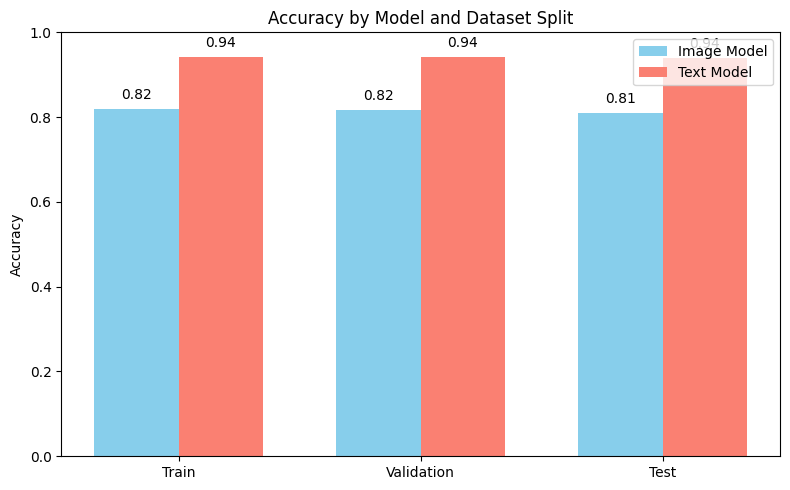

In [38]:
image_accuracies = [acc_img_train, acc_img_val, acc_img_test]
text_accuracies = [acc_text_train, acc_text_val, acc_text_test]
labels = ['Train', 'Validation', 'Test']

# Plotting
x = np.arange(len(labels))  # label locations
width = 0.35  # bar width

fig, ax = plt.subplots(figsize=(8, 5))
rects1 = ax.bar(x - width/2, image_accuracies, width, label='Image Model', color='skyblue')
rects2 = ax.bar(x + width/2, text_accuracies, width, label='Text Model', color='salmon')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy by Model and Dataset Split')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylim(0, 1.0)
ax.legend()

# Label bars with values
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 5),  # offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

plt.tight_layout()
plt.show()

# Combing Image + Text Features

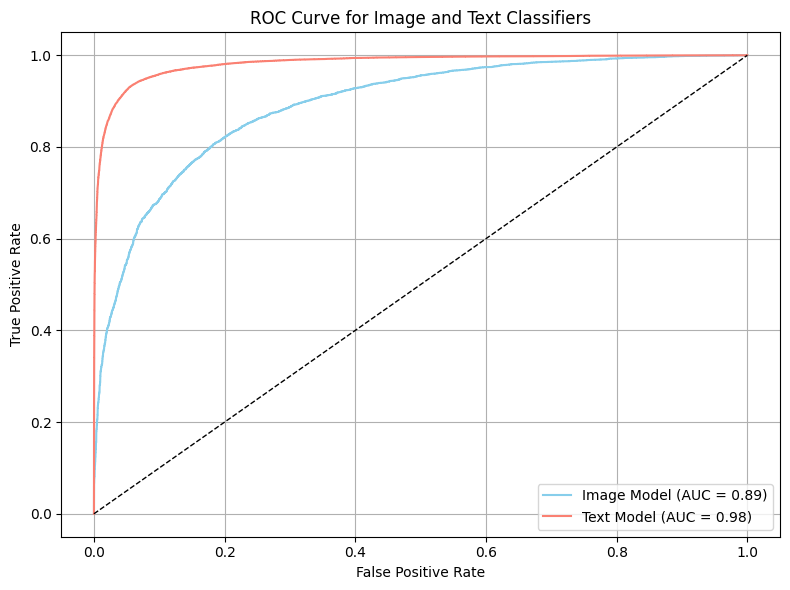

In [39]:
img_test_probs = img_clf.predict_proba(img_test_feats)[:, 1]
fpr_img, tpr_img, _ = roc_curve(img_test_labels, img_test_probs)
auc_img = auc(fpr_img, tpr_img)

# Text model: predict probabilities
text_test_probs = text_clf.predict_proba(text_test_feats)[:, 1]
fpr_text, tpr_text, _ = roc_curve(text_test_labels, text_test_probs)
auc_text = auc(fpr_text, tpr_text)

# Plotting
plt.figure(figsize=(8, 6))
plt.plot(fpr_img, tpr_img, label=f'Image Model (AUC = {auc_img:.2f})', color='skyblue')
plt.plot(fpr_text, tpr_text, label=f'Text Model (AUC = {auc_text:.2f})', color='salmon')

# Diagonal line for random classifier
plt.plot([0, 1], [0, 1], 'k--', lw=1)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Image and Text Classifiers')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

# Add performance matrix

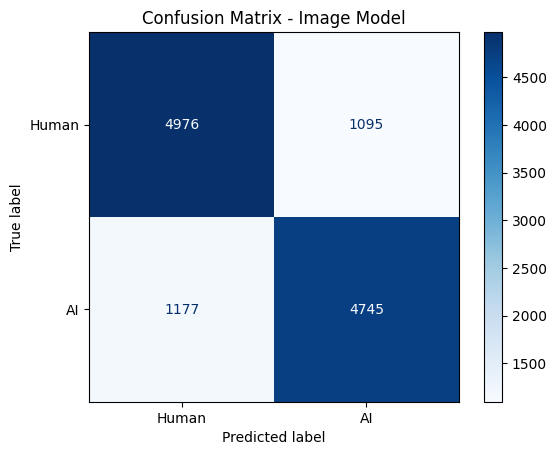

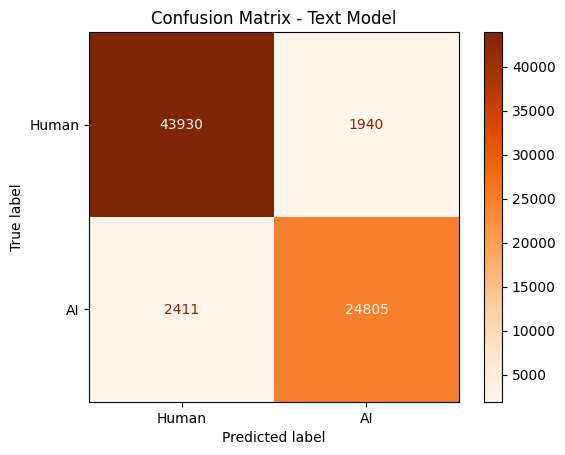

In [40]:
img_test_preds = img_clf.predict(img_test_feats)
text_test_preds = text_clf.predict(text_test_feats)

# Confusion matrix for image model
cm_img = confusion_matrix(img_test_labels, img_test_preds)
disp_img = ConfusionMatrixDisplay(confusion_matrix=cm_img, display_labels=['Human', 'AI'])
disp_img.plot(cmap='Blues')
plt.title("Confusion Matrix - Image Model")
plt.show()

# Confusion matrix for text model
cm_text = confusion_matrix(text_test_labels, text_test_preds)
disp_text = ConfusionMatrixDisplay(confusion_matrix=cm_text, display_labels=['Human', 'AI'])
disp_text.plot(cmap='Oranges')
plt.title("Confusion Matrix - Text Model")
plt.show()

In [28]:
print("=== Classification Report: Image Model ===")
print(classification_report(img_test_labels, img_test_preds, target_names=['Human', 'AI']))

print("\n=== Classification Report: Text Model ===")
print(classification_report(text_test_labels, text_test_preds, target_names=['Human', 'AI']))

=== Classification Report: Image Model ===
              precision    recall  f1-score   support

       Human       0.85      0.85      0.85      6057
          AI       0.84      0.84      0.84      5936

    accuracy                           0.85     11993
   macro avg       0.85      0.85      0.85     11993
weighted avg       0.85      0.85      0.85     11993


=== Classification Report: Text Model ===
              precision    recall  f1-score   support

       Human       0.95      0.96      0.95     45870
          AI       0.93      0.91      0.92     27216

    accuracy                           0.94     73086
   macro avg       0.94      0.93      0.94     73086
weighted avg       0.94      0.94      0.94     73086



In [18]:
vectorizer = TfidfVectorizer(max_features=5000)
X_tfidf = vectorizer.fit_transform(text_df['text'])
X_train_tfidf, X_temp_tfidf, y_train_tfidf, y_temp_tfidf = train_test_split(
    X_tfidf, text_df['generated'], test_size=0.3, stratify=text_df['generated'], random_state=42)
X_val_tfidf, X_test_tfidf, y_val_tfidf, y_test_tfidf = train_test_split(
    X_temp_tfidf, y_temp_tfidf, test_size=0.5, stratify=y_temp_tfidf, random_state=42)

# Train TF-IDF classifier
clf_tfidf = LogisticRegression(max_iter=1000)
clf_tfidf.fit(X_train_tfidf, y_train_tfidf)
tfidf_preds = clf_tfidf.predict(X_test_tfidf)
tfidf_probs = clf_tfidf.predict_proba(X_test_tfidf)[:, 1]
acc_tfidf_train = evaluate(clf_tfidf, X_train_tfidf, y_train_tfidf, "TF-IDF Train")
acc_tfidf_val = evaluate(clf_tfidf, X_val_tfidf, y_val_tfidf, "TF-IDF Val")
acc_tfidf_test = evaluate(clf_tfidf, X_test_tfidf, y_test_tfidf, "TF-IDF Test")
fpr_tfidf, tpr_tfidf, _ = roc_curve(y_test_tfidf, tfidf_probs)
auc_tfidf = auc(fpr_tfidf, tpr_tfidf)

# Already available:
# text_test_labels = true labels
# text_test_preds = SentenceTransformer predictions (from earlier)

# Construct contingency table
b01 = np.sum((text_test_preds == text_test_labels) & (tfidf_preds != text_test_labels))
b10 = np.sum((text_test_preds != text_test_labels) & (tfidf_preds == text_test_labels))
contingency_table_text = [[0, b01],
                          [b10, 0]]

# Run McNemar’s test
result_text = mcnemar(contingency_table_text, exact=True)
print("\n=== McNemar’s Test (SentenceTransformer vs TF-IDF) ===")
print(f"Statistic: {result_text.statistic}, p-value: {result_text.pvalue}")
if result_text.pvalue < 0.05:
    print("✅ Statistically significant difference")
else:
    print("❌ No statistically significant difference")

TF-IDF Train Accuracy: 0.9917
TF-IDF Val Accuracy: 0.9913
TF-IDF Test Accuracy: 0.9914

=== McNemar’s Test (SentenceTransformer vs TF-IDF) ===
Statistic: 269.0, p-value: 0.0
✅ Statistically significant difference


In [41]:
class MobileNetImageEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        base_model = models.mobilenet_v2(pretrained=True)
        self.encoder = base_model.features  # feature extractor
        self.pool = nn.AdaptiveAvgPool2d((1, 1))  # to flatten

    def forward(self, x):
        with torch.no_grad():
            x = self.encoder(x)
            x = self.pool(x)
            x = x.view(x.size(0), -1)
        return x
mobilenet_encoder = MobileNetImageEncoder().to(device)

def extract_mobile_features(dset):
    loader = DataLoader(dset, batch_size=64)
    features, labels = [], []
    for imgs, lbls in tqdm(loader, desc="Extracting MobileNet Features"):
        feats = mobilenet_encoder(imgs.to(device)).cpu().numpy()
        features.extend(feats)
        labels.extend(lbls)
    return np.array(features), np.array(labels)

# Extract features
mobile_train_feats, mobile_train_labels = extract_mobile_features(img_train)
mobile_val_feats, mobile_val_labels = extract_mobile_features(img_val)
mobile_test_feats, mobile_test_labels = extract_mobile_features(img_test)
mobile_clf = LogisticRegression(max_iter=1000)
mobile_clf.fit(mobile_train_feats, mobile_train_labels)
mobile_preds = mobile_clf.predict(mobile_test_feats)
mobile_probs = mobile_clf.predict_proba(mobile_test_feats)[:, 1]
acc_mobile_train = evaluate(mobile_clf, mobile_train_feats, mobile_train_labels, "MobileNet Train")
acc_mobile_val = evaluate(mobile_clf, mobile_val_feats, mobile_val_labels, "MobileNet Val")
acc_mobile_test = evaluate(mobile_clf, mobile_test_feats, mobile_test_labels, "MobileNet Test")
fpr_mobile, tpr_mobile, _ = roc_curve(mobile_test_labels, mobile_probs)
auc_mobile = auc(fpr_mobile, tpr_mobile)

b01 = np.sum((img_test_preds == img_test_labels) & (mobile_preds != img_test_labels))
b10 = np.sum((img_test_preds != img_test_labels) & (mobile_preds == img_test_labels))
contingency_table_img = [[0, b01],
                         [b10, 0]]

from statsmodels.stats.contingency_tables import mcnemar
result_img = mcnemar(contingency_table_img, exact=True)
p_img_models = result_img.pvalue
print(f"\nMcNemar Test (ResNet vs MobileNet) p-value: {p_img_models:.4f}")
result_img = mcnemar(contingency_table_img, exact=True)
print("\n=== McNemar’s Test (ResNet vs MobileNet) ===")
print(f"Statistic: {result_img.statistic}, p-value: {result_img.pvalue}")
if result_img.pvalue < 0.05:
    print("✅ Statistically significant difference")
else:
    print("❌ No statistically significant difference")


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Extracting MobileNet Features: 100%|██████████| 188/188 [03:13<00:00,  1.03s/it]


MobileNet Train Accuracy: 0.8625
MobileNet Val Accuracy: 0.8507
MobileNet Test Accuracy: 0.8505

McNemar Test (ResNet vs MobileNet) p-value: 0.0000

=== McNemar’s Test (ResNet vs MobileNet) ===
Statistic: 955.0, p-value: 9.964021936965475e-23
✅ Statistically significant difference


In [42]:
# Calculate average precision
comparison_data = {
    "Model": [
        "ResNet + LR",
        "MobileNet + LR",
        "SentenceTransformer + LR",
        "TF-IDF + LR"
    ],
    "Accuracy (Test)": [
        acc_img_test,
        acc_mobile_test,
        acc_text_test,
        acc_tfidf_test
    ],
    "AUC": [
        auc_img,
        auc_mobile,
        auc_text,
        auc_tfidf
    ],
    "Avg Precision": [
        ap_img,
        ap_mobile,
        ap_text,
        ap_tfidf
    ],
    "McNemar p-value": [
        np.nan,
        p_img_models,
        np.nan,
        result_text.pvalue
    ]
}

df = pd.DataFrame(comparison_data)

# === Identify best models
for metric in ["Accuracy (Test)", "AUC", "Avg Precision"]:
    max_idx = df[metric].idxmax()
    df.loc[max_idx, metric] = f"{df.loc[max_idx, metric]:.3f} ✓"
    for i in df.index:
        if i != max_idx:
            df.loc[i, metric] = f"{df.loc[i, metric]:.3f}"

# === Format McNemar p-values
df["McNemar p-value"] = df["McNemar p-value"].apply(
    lambda x: f"{x:.4f}" if not pd.isna(x) else "—"
)

# === Final tabulated output
print("\n=== Final Systematic Model Comparison Table ===")
print(tabulate(df, headers='keys', tablefmt='grid', showindex=False))

# === Interpretation
print("\n--- Systematic Analysis Summary ---")

# Image comparison
if p_img_models < 0.05:
    print(f"✔️ MobileNet vs ResNet: Significant difference (p={p_img_models:.4f}) — choose based on higher accuracy or AUC.")
else:
    print(f"❌ MobileNet vs ResNet: No significant difference (p={p_img_models:.4f})")

# Text comparison
if result_text.pvalue < 0.05:
    print(f"✔️ TF-IDF vs SentenceTransformer: Significant difference (p={result_text.pvalue:.4f}) — choose best on metrics.")
else:
    print(f"❌ TF-IDF vs SentenceTransformer: No significant difference (p={result_text.pvalue:.4f})")


=== Final Systematic Model Comparison Table ===
+--------------------------+-------------------+---------+-----------------+-------------------+
| Model                    | Accuracy (Test)   | AUC     | Avg Precision   | McNemar p-value   |
+==========================+===================+=========+=================+===================+
| ResNet + LR              | 0.811             | 0.892   | 0.891           | —                 |
+--------------------------+-------------------+---------+-----------------+-------------------+
| MobileNet + LR           | 0.850             | 0.925   | 0.924           | 0.0000            |
+--------------------------+-------------------+---------+-----------------+-------------------+
| SentenceTransformer + LR | 0.940             | 0.982   | 0.975           | —                 |
+--------------------------+-------------------+---------+-----------------+-------------------+
| TF-IDF + LR              | 0.991 ✓           | 0.999 ✓ | 0.999 ✓         | 0

/tmp/ipython-input-42-854702856.py:40: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.991 ✓' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[max_idx, metric] = f"{df.loc[max_idx, metric]:.3f} ✓"
/tmp/ipython-input-42-854702856.py:40: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.999 ✓' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[max_idx, metric] = f"{df.loc[max_idx, metric]:.3f} ✓"
/tmp/ipython-input-42-854702856.py:40: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.999 ✓' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[max_idx, metric] = f"{df.loc[max_idx, metric]:.3f} ✓"
